In [989]:
# DSC 540
# Week 3 & 4
# Summer 2024
# Term Project Milestone 2
# Created By Matthew Heinen
# 6/24/24

# Weather and Carlos Santana’s Effectiveness
# DSC 540: Milestone 2 

In [991]:
# Import packages. 

import pandas as pd

In [992]:
# Read in flat file data set from baseball savant. 

# Use read_csv to read the CSV into a DataFrame. 
carlos = pd.read_csv('santana_road_bip.csv')

# Preview first couple lines. 
carlos.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
0,FF,2013-07-05,101.5,-1.41,6.06,"Rondón, Bruce",467793,541652,single,hit_into_play,...,0,0,7,NaN,NaN,NaN,0.001,0.410,NaN,NaN
1,SI,2018-06-19,101.2,-1.43,6.18,"Hicks, Jordan",467793,663855,field_out,hit_into_play,...,6,6,7,Standard,Standard,245.0,-0.086,-0.232,NaN,NaN
2,FF,2015-05-24,100.9,0.84,6.34,"Chapman, Aroldis",467793,547973,single,hit_into_play,...,5,5,1,Standard,Standard,NaN,0.012,0.578,NaN,NaN
3,FF,2012-09-29,100.9,-1.95,5.90,"Herrera, Kelvin",467793,516969,field_out,hit_into_play,...,6,6,7,NaN,NaN,NaN,-0.201,-0.523,NaN,NaN
4,SI,2019-05-26,100.5,0.86,6.66,"Alvarado, José",467793,621237,force_out,hit_into_play,...,3,3,6,Standard,Standard,143.0,-0.040,-0.459,NaN,NaN


## Transformation 1: Remove Unnecessary Columns

    As we can see above our data set has 94 columns, some of which are either unnecessary or unusable for our project scope. Our first step will be dropping these unnecessary columns. 

First we must print the names of all the columns so we know which ones to drop. We will also print column index in the case we would like to bulk drop. 

In [995]:
# Print column names and their corresponding index

# Loop through each column and print its name and coresponding index. 
for index, column_name in enumerate(carlos.columns):
    print(f"Column: '{column_name}' index: {index}")

Column: 'pitch_type' index: 0
Column: 'game_date' index: 1
Column: 'release_speed' index: 2
Column: 'release_pos_x' index: 3
Column: 'release_pos_z' index: 4
Column: 'player_name' index: 5
Column: 'batter' index: 6
Column: 'pitcher' index: 7
Column: 'events' index: 8
Column: 'description' index: 9
Column: 'spin_dir' index: 10
Column: 'spin_rate_deprecated' index: 11
Column: 'break_angle_deprecated' index: 12
Column: 'break_length_deprecated' index: 13
Column: 'zone' index: 14
Column: 'des' index: 15
Column: 'game_type' index: 16
Column: 'stand' index: 17
Column: 'p_throws' index: 18
Column: 'home_team' index: 19
Column: 'away_team' index: 20
Column: 'type' index: 21
Column: 'hit_location' index: 22
Column: 'bb_type' index: 23
Column: 'balls' index: 24
Column: 'strikes' index: 25
Column: 'game_year' index: 26
Column: 'pfx_x' index: 27
Column: 'pfx_z' index: 28
Column: 'plate_x' index: 29
Column: 'plate_z' index: 30
Column: 'on_3b' index: 31
Column: 'on_2b' index: 32
Column: 'on_1b' inde

In [996]:
# Remove all fielder values 
# Use drop method remove columns 59-67
carlos = carlos.drop(carlos.columns[59:68], axis=1)

# View new size of df to validate drop. 
carlos.shape

(2831, 85)

In [997]:
# Remove batter index as all batters are Carlos Santana. 
carlos = carlos.drop('batter', axis=1)

# Remove description as all are balls hit into play 
carlos = carlos.drop('description', axis=1)

# Remove game year as its rebetitive with date. 
carlos = carlos.drop('game_year', axis=1)

# Remove type as its tells us nothing. 
carlos = carlos.drop('type', axis=1)

# Remove the second fielder_2 repetitive. 
carlos = carlos.drop('fielder_2', axis=1)

# Remove strikezone top as it is irrelevent to our project. 
carlos = carlos.drop('sz_top', axis=1)

# Remove Strikezone bottom as it is irrelevant to our project. 
carlos = carlos.drop('sz_bot', axis=1)

# Remove sv_id : unnecessary. 
carlos = carlos.drop('sv_id', axis=1)

# View new size of df to validate drop. 
carlos.shape

(2831, 77)

Looking at the data set there appears there may be some columns that are entirely empty. Lets remove the entirely empty columns. 

In [999]:
# Test if a column is entirely null
# Use isnull and all to select the columd from the df with no values. 
null_columns = carlos.columns[carlos.isnull().all()]

# Delete entirely null columns from the carlos dataset using drop. 
carlos = carlos.drop(null_columns, axis=1)

# View new size of df to validate drop. 
carlos.shape

(2831, 70)

Now lets revaluate where are dataset is at and see which columns to remove next. 

In [1001]:
# Print column names and their corresponding index

# Loop through each column and print its name and coresponding index. 
for index, column_name in enumerate(carlos.columns):
    print(f"Column: '{column_name}' index: {index}")

Column: 'pitch_type' index: 0
Column: 'game_date' index: 1
Column: 'release_speed' index: 2
Column: 'release_pos_x' index: 3
Column: 'release_pos_z' index: 4
Column: 'player_name' index: 5
Column: 'pitcher' index: 6
Column: 'events' index: 7
Column: 'zone' index: 8
Column: 'des' index: 9
Column: 'game_type' index: 10
Column: 'stand' index: 11
Column: 'p_throws' index: 12
Column: 'home_team' index: 13
Column: 'away_team' index: 14
Column: 'hit_location' index: 15
Column: 'bb_type' index: 16
Column: 'balls' index: 17
Column: 'strikes' index: 18
Column: 'pfx_x' index: 19
Column: 'pfx_z' index: 20
Column: 'plate_x' index: 21
Column: 'plate_z' index: 22
Column: 'on_3b' index: 23
Column: 'on_2b' index: 24
Column: 'on_1b' index: 25
Column: 'outs_when_up' index: 26
Column: 'inning' index: 27
Column: 'inning_topbot' index: 28
Column: 'hc_x' index: 29
Column: 'hc_y' index: 30
Column: 'vx0' index: 31
Column: 'vy0' index: 32
Column: 'vz0' index: 33
Column: 'ax' index: 34
Column: 'ay' index: 35
Col

Now we will bulk remove the directional pitch velocity and acceleration columns. These datapoints are too specific for our level of analysis in this projet. These columns are currently named: vx0, vyo, ax, ay, and az. We will also remove the hit cordinate values as they are also too specific. These columns are named: hc_x and hc_y


In [1003]:
# Remove all directional pitch velocity and acceleration values 
# Also remove Hit cordinate values. 
# Use drop method remove columns 29-36
carlos = carlos.drop(carlos.columns[29:37], axis=1)

# View new size of df to validate drop. 
carlos.shape

(2831, 62)

In [1004]:
# Remove woba_value
# column is unecessary. 
carlos = carlos.drop('woba_value', axis=1)

# Remove woba_denom
carlos = carlos.drop('woba_denom', axis=1)

## Transformation 2: Make on_1b , on_2b and on_3b Binary. 

Here we are not concerned with which player is on base just which bases are occupied. This will still allow us to evaluate situational hitting and clean our database making it easier to analyze later. 

In [1006]:
# Build function to test if a column had content and apply a binary based on the result. 

def replace_with_binary(value):
    #If the value is empty return zero. 
    if pd.isna(value):
        return 0
    # Add clause in case you run code twice. 
    elif value == 0:
        return 0 
    #If there is a runner on the base return 1. 
    else:
        return 1

In [1007]:
# Use the apply method to loop through each of the on base columns and call 
# replace_with_binary function. 

# First base. 
carlos['on_1b'] = carlos['on_1b'].apply(replace_with_binary)

# Second base. 
carlos['on_2b'] = carlos['on_2b'].apply(replace_with_binary)

# Third base. 
carlos['on_3b'] = carlos['on_3b'].apply(replace_with_binary)

# Preview the results of the onbase columns. 
print(carlos[['on_1b', 'on_2b', 'on_3b']].head(10))


   on_1b  on_2b  on_3b
0      1      0      0
1      0      0      0
2      0      1      0
3      1      1      1
4      1      0      1
5      0      1      0
6      0      0      0
7      0      0      0
8      1      1      0
9      1      0      0


# Transformation 3: Convert Date into Unix Time (UTC Time Zone). 

This transformation will be done by assigning a start time of 7 pm (most common start time in baseball to all games. Additionally a transformation will be done to unix time which is required for our API weather call. 

In [1009]:
# Convert date column to Unix time
# Add this column to the Data Frame
# Use game_date and to_datetime method to convert to unix. 
carlos['unix_time'] = pd.to_datetime(carlos['game_date']).astype(int) // 10**9

# Add a column that assumes a 7pm start time for every game. 
# Convert Unix time to 7pm
# During daylight savings, CDT is 5 hours behing UTC. 
# to get 7pm or 19:00 we need to add 5 more hours to catch up making for 24 hours. 
carlos['unix_time'] = carlos['unix_time'] + (24 * 3600)  # 26 hours * 3600 seconds/hour

# Create a game date_time to validate the Unix time. 


# Preview the result of the time related columns. 
# Preview the results of the onbase columns. 
print(carlos[['game_date', 'unix_time']].head(10))

    game_date   unix_time
0  2013-07-05  1373068800
1  2018-06-19  1529452800
2  2015-05-24  1432512000
3  2012-09-29  1348963200
4  2019-05-26  1558915200
5  2023-06-03  1685836800
6  2019-09-14  1568505600
7  2022-04-11  1649721600
8  2018-06-25  1529971200
9  2012-07-08  1341792000


Here we see that we have left our game date and converted to 7pm Central in UTC Unix time 

# Transformation 4: Rename Confusing names from Baseball Savant 

Baseball Savant uses some naming systems that are either not descriptive or confusing. In this section we will select those columns and rename them with and intuitive and consistent naming system. 

Note the naming convention documentation can be found here: https://baseballsavant.mlb.com/csv-docs

In [1012]:
# In this section we wil use the rename method to rename some coulumne to our naming conventions. 

# Rename player_name to pitcher_name
carlos = carlos.rename(columns={'player_name': 'pitcher_name'})

# Rename pitcher to pitcher_id
carlos = carlos.rename(columns={'pitcher': 'pitcher_id'})

# Rename game_pk to game_id
carlos = carlos.rename(columns={'game_pk': 'game_id'})

# Rename des to description
carlos = carlos.rename(columns={'des': 'description'})

# Rename stand to batter_stance. 
# This is more clear to which way the batter is swinging the bat right or left handed. 
carlos = carlos.rename(columns={'stand': 'batter_stance'})

# Rename pfx_x to pitch_hor_break
# This naming convention is more clear that it is describing:
# Horizontal movement in feet from the catcher's perspective.
carlos = carlos.rename(columns={'pfx_x': 'pitch_hor_break'})

# Rename pfx_z to pitch_ver_break
# This naming convention is more clear that it is describing:
# Vertical movement in feet from the catcher's perpsective.
carlos = carlos.rename(columns={'pfx_z': 'pitch_ver_break'})

# Rename launce_speed_angle to contact_type. 
# This naming convention better describes what kind and quality of contact a batter makes. 
carlos = carlos.rename(columns={'launch_speed_angle': 'contact_type'})

# Rename zone to pitch_zone_location. 
carlos = carlos.rename(columns={'zone': 'pitch_zone_location'})

# Rename events to ab_result: 
# Better describes what happens as a result of the at bat. 
carlos = carlos.rename(columns={'events': 'ab_result'})

In [1013]:
# Print column names and their corresponding index
# Do this to visualise our data set. 

# Loop through each column and print its name and coresponding index. 
for index, column_name in enumerate(carlos.columns):
    print(f"Column: '{column_name}' index: {index}")

Column: 'pitch_type' index: 0
Column: 'game_date' index: 1
Column: 'release_speed' index: 2
Column: 'release_pos_x' index: 3
Column: 'release_pos_z' index: 4
Column: 'pitcher_name' index: 5
Column: 'pitcher_id' index: 6
Column: 'ab_result' index: 7
Column: 'pitch_zone_location' index: 8
Column: 'description' index: 9
Column: 'game_type' index: 10
Column: 'batter_stance' index: 11
Column: 'p_throws' index: 12
Column: 'home_team' index: 13
Column: 'away_team' index: 14
Column: 'hit_location' index: 15
Column: 'bb_type' index: 16
Column: 'balls' index: 17
Column: 'strikes' index: 18
Column: 'pitch_hor_break' index: 19
Column: 'pitch_ver_break' index: 20
Column: 'plate_x' index: 21
Column: 'plate_z' index: 22
Column: 'on_3b' index: 23
Column: 'on_2b' index: 24
Column: 'on_1b' index: 25
Column: 'outs_when_up' index: 26
Column: 'inning' index: 27
Column: 'inning_topbot' index: 28
Column: 'hit_distance_sc' index: 29
Column: 'launch_speed' index: 30
Column: 'launch_angle' index: 31
Column: 'ef

# Transformation 5: Evaluate Missing Data

Now as we evaluate our dataset we recognise that there are some columns with missing data and quite alot of it. We will determine what to do with that data on a case by case basis given the condition. 


In [1015]:
# First we will determine which columns have missing data and how many rows are missing data
# Use isnull and sum to determine the columns missing data and sum to count the rows 
missing_values = carlos.isnull().sum()

# print columes with missing values and number of rows missing. 
print("Columns with missing values:")
# Loop though the series missing values for every column. 
for column, missing_count in missing_values.items():
    # If data is missing 
    if missing_count > 0:
        #print column name, number of missing values and percent missing 
        print(f"'{column}' has {missing_count} missing value(s), missing percent : {(missing_count/carlos.shape[0])*100})%")

Columns with missing values:
'hit_location' has 154 missing value(s), missing percent : 5.439773931472978)%
'hit_distance_sc' has 975 missing value(s), missing percent : 34.44012716354645)%
'launch_speed' has 872 missing value(s), missing percent : 30.801836806782056)%
'launch_angle' has 872 missing value(s), missing percent : 30.801836806782056)%
'effective_speed' has 869 missing value(s), missing percent : 30.695867184740372)%
'release_spin_rate' has 896 missing value(s), missing percent : 31.64959378311551)%
'release_extension' has 868 missing value(s), missing percent : 30.660543977393147)%
'estimated_ba_using_speedangle' has 872 missing value(s), missing percent : 30.801836806782056)%
'estimated_woba_using_speedangle' has 872 missing value(s), missing percent : 30.801836806782056)%
'contact_type' has 872 missing value(s), missing percent : 30.801836806782056)%
'if_fielding_alignment' has 883 missing value(s), missing percent : 31.190392087601555)%
'of_fielding_alignment' has 883 m

Anything where we are missing over 95% of the data is going to be more or less unusable for this project. Therefore we will remove bat_speed and swing_length from our dataset. 

In [1017]:
# Remove bat_speed and swing_length. 
carlos = carlos.drop(['bat_speed', 'swing_length'], axis=1)

# View new size of df to validate drop. 
carlos.shape

(2831, 59)

The rest of the columns have enough rows that we can work with them moving forward. We will leave them in the dataset with no further transformations. 

# Transformation 6: Outliers

    In this section we seek to remove outliers from the data. The two variables that we will use to evaluate that most heavily are launch speed and launch angle. However it is understandable that over Santana's 17 year MLB career their may be some outliers. In this section we will remove those outliers by evaluating the above variables box plot. We will chalk these instances or events that we remove as "fluke plays".  

In [1020]:
# Import packages 
import matplotlib.pyplot as plt

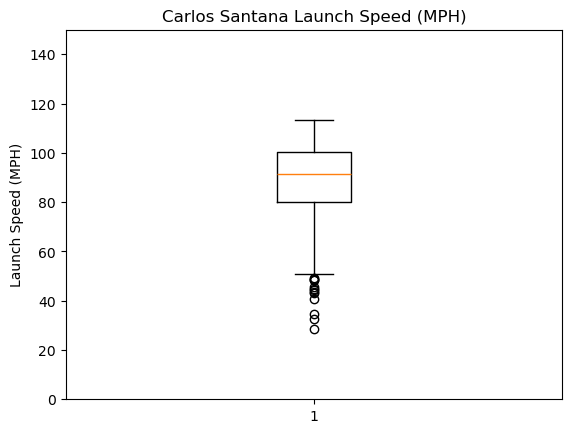

Whisker values: [array([80.25, 50.9 ]), array([100.4, 113.5])]


In [1021]:
# Create a boxplot of launch_speed to evaluate for outliers 
# Build boxplot
boxplot=plt.boxplot(carlos.launch_speed.dropna())

# Adjust the y-axis limits to show stats. 
plt.ylim(0, 150) 

# title
plt.title('Carlos Santana Launch Speed (MPH)')

# Axis title 
plt.ylabel('Launch Speed (MPH)')

#Show
plt.show()


# Show the values of the whiskers
# This will allow us to determine how to filter our dataset and eliminate outliers. 
# Get whisker vaules 
whisker_values = [whiskers.get_ydata() for whiskers in boxplot['whiskers']]

# Print Whisker values.
print("Whisker values:", whisker_values)

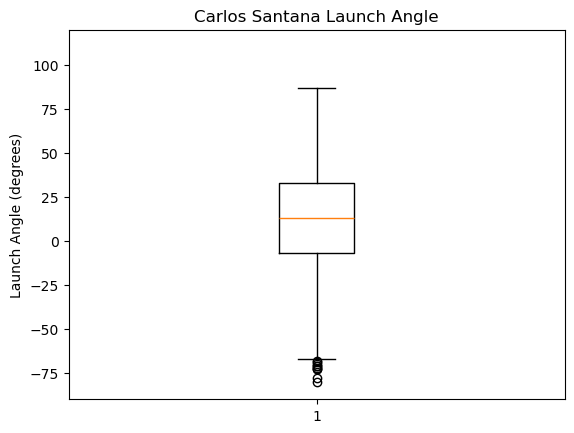

Whisker values: [array([ -7., -67.]), array([33., 87.])]


In [1022]:
# Create a boxplot of launch_angle to evaluate for outliers 
# Build boxplot
boxplot=plt.boxplot(carlos.launch_angle.dropna())

# Adjust the y-axis limits to show stats. 
plt.ylim(-90, 120) 

# title
plt.title('Carlos Santana Launch Angle')

# Axis title 
plt.ylabel('Launch Angle (degrees)')

#Show
plt.show()


# Show the values of the whiskers
# This will allow us to determine how to filter our dataset and eliminate outliers. 
# Get whisker vaules 
whisker_values = [whiskers.get_ydata() for whiskers in boxplot['whiskers']]

# Print Whisker values.
print("Whisker values:", whisker_values)

Based on the results of our boxplots above we can remove outliers where the launch speed is less than 50.9 MPH and launch angle is below -67 degrees. 

In [1024]:
# Determine the pre-outlier dataframe size. 
pre_outlier_size = carlos.shape

#print
print(pre_outlier_size)

(2831, 59)


In [1025]:
# Filter outliers. 
# keep records where launch_speed > 50.9
# keep records where launch_angle > -67

carlos_no = carlos[(carlos['launch_speed'] > 50.9) & (carlos['launch_angle'] > -67)]

In [1026]:
# Determine the post-outlier dataframe size. 
post_outlier_size = carlos_no.shape

# Print final df size. 
print('The final size of the data set: ', post_outlier_size)

# Print how many outilers removed
print('Outliers Removed: ', pre_outlier_size[0]- post_outlier_size[0])

The final size of the data set:  (1936, 59)
Outliers Removed:  895


# Ethical Implications of Data Wrangling

        In this milestone we made seven different transformations to our data: removed unnecessary columns, converted runners on base to be binary, converted the game date to Unix in the UTC time zone, renamed columns for clarity, removed columns that were missing too much data. And removed outliers from launch speed and angle. One assumption was to make all the times we will use for our API weather data call at 7pm central time. Naturally, this does not consider day games, different time zones and differing start times. As a result, this will affect the legitimacy of our project and results as we try to evaluate how weather affects Carlos Santana's Performance.   

        Another ethical impact that our data wrangling may have caused is how we chose to eliminate outliers. By eliminating very low launch speed and angle events or our “fluke plays”, there is a potential that we eliminated some plays that resulted in hits.  It is possible that by removing these outliers we may be evaluating Santana without skill plays that had a positive impact on his performance like a bunt single or hit and run play. One transformation that was done to mitigate any ethical impact was to not evaluate swing speed or length. There was simply not enough data to evaluate, and the two columns were removed from the dataset. These new stats were only tracked for the 2024 season. It would have been unethical to evaluate Santana’s performance based only on a couple months of plate appearances. Overall, I am very confident in the accuracy and legitimacy of this final data set. Data was queried directly from Baseball Savant, Major League Baseball's advanced statistic database. Because of the credibility of the source, I am confident that the data is accurate and acquired ethically as Major League Baseball is required to notify players of recorded data.   

# Display Final Dataset

In [1030]:
# Display final dataset in a human readable way. 

print(carlos_no)

#Display first 25 lines to improve context. 
print(carlos_no.head(25))

     pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
1            SI  2018-06-19          101.2          -1.43           6.18   
2            FF  2015-05-24          100.9           0.84           6.34   
4            SI  2019-05-26          100.5           0.86           6.66   
5            FF  2023-06-03          100.2          -1.47           6.24   
6            FF  2019-09-14          100.1          -1.55           6.44   
...         ...         ...            ...            ...            ...   
2822         CU  2015-06-17           71.6           2.05           5.10   
2824         CU  2021-08-18           70.7          -0.94           6.31   
2827         CU  2015-04-30           68.9           3.54           5.86   
2828         CS  2020-08-25           68.1           1.36           6.12   
2829         CH  2015-07-06           67.6          -2.46           5.28   

           pitcher_name  pitcher_id  ab_result  pitch_zone_location  \
1         Hicks,

In [1031]:
#Display first 25 lines to improve context. 
print(carlos_no.head(25))

   pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
1          SI  2018-06-19          101.2          -1.43           6.18   
2          FF  2015-05-24          100.9           0.84           6.34   
4          SI  2019-05-26          100.5           0.86           6.66   
5          FF  2023-06-03          100.2          -1.47           6.24   
6          FF  2019-09-14          100.1          -1.55           6.44   
7          FC  2022-04-11          100.1          -0.46           6.06   
8          FF  2018-06-25          100.0           0.51           6.14   
10         FF  2017-08-21           99.7          -2.03           5.91   
11         FF  2019-07-18           99.7          -1.36           6.15   
13         FF  2024-05-07           99.5          -0.49           6.65   
14         FF  2020-09-09           99.5          -0.69           6.49   
16         FF  2018-08-16           99.1          -0.46           5.72   
17         FF  2018-04-28           99

In [1032]:
# Display last 25 lines to improve context. 
print(carlos_no.tail(25))

     pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
2792         CU  2022-04-11           74.9          -0.93           6.12   
2793         CU  2022-05-20           74.9           2.28           5.89   
2794         CU  2015-06-11           74.7          -1.55           6.54   
2796         CU  2015-07-28           74.6           1.99           6.02   
2799         CU  2021-04-20           74.4           1.49           5.89   
2801         ST  2023-08-26           74.3           2.78           4.54   
2802         CU  2018-04-07           74.2           1.99           5.74   
2804         CU  2017-04-30           74.2           1.74           5.92   
2806         CU  2022-08-05           74.1          -2.32           4.82   
2807         CU  2017-06-15           73.9           1.79           5.91   
2808         CU  2021-08-19           73.9          -2.03           5.21   
2810         KC  2017-09-15           73.4           2.94           5.38   
2811        